# Robust Neural Network: MNIST example

In this example, we train a simple network that is robust to adversarial noise. 

# Import Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn
seaborn.set(font_scale=2)
seaborn.set_style("white")

import sys
sys.path.append("../")

import numpy as np
from scipy.spatial import HalfspaceIntersection
import warnings

pritn = print

from convex_adversarial import robust_loss

In [2]:
## 어떤 python에서 돌아가는지
## 환경, 버전
print(sys.executable)

/home/tako/anaconda3/envs/lsy/bin/python


In [3]:
print(sys.path)

['', '/home/tako/anaconda3/envs/lsy/lib/python36.zip', '/home/tako/anaconda3/envs/lsy/lib/python3.6', '/home/tako/anaconda3/envs/lsy/lib/python3.6/lib-dynload', '/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages', '/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg', '/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages/IPython/extensions', '/home/tako/.ipython', '../']


In [4]:
## warning 없애기
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
### GPU 연결 확인
print(torch.cuda.current_device()) #연결된 gpu idx
print(torch.cuda.device(0))
print(torch.cuda.device_count()) #연결된 gpu갯수
print(torch.cuda.get_device_name(0)) #연결된 gpu이름

0
2
TITAN Xp


In [6]:
torch.cuda.set_device(1)

# Set Parameters

In [7]:
batch_size = 50

#  Load data

In [8]:
mnist_trainset = datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())
data_loader  = torch.utils.data.DataLoader(dataset=mnist_trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)
test_data_loader  = torch.utils.data.DataLoader(dataset=mnist_testset,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=1)

In [9]:
n_samples = mnist_trainset.train_data.shape[0]

In [10]:
mnist_trainset.train_data.shape, mnist_testset.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [11]:
mnist_trainset.train_labels.shape, mnist_testset.test_labels.shape

(torch.Size([60000]), torch.Size([10000]))

max and min 255 0


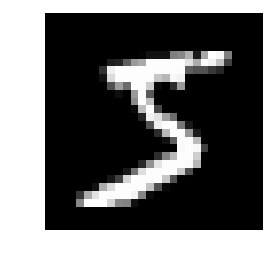

In [12]:
train_ex = mnist_trainset.train_data[0].numpy()
print('max and min', train_ex.max(), train_ex.min())
plt.imshow(train_ex, 'gray')
plt.axis('off')
plt.show()

In [13]:
X_train = mnist_trainset.train_data
y_train = mnist_trainset.train_labels
X_test = mnist_testset.test_data
y_test = mnist_testset.test_labels

In [14]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

## Robust Neural Network

In [15]:
epsilon = 0.1 #0.5

In [16]:
#torch.manual_seed(1)
robust_net = nn.Sequential(
    nn.Conv2d(1,16, 2, stride=(2,2)),
    nn.ReLU(),
    nn.Conv2d(16,32, 2, stride=(2,2)),
    nn.ReLU(),
    Flatten(),
    nn.Linear(7*7*32,100),
    nn.ReLU(),
    nn.Linear(100,10)
)

data = []
opt = optim.Adam(robust_net.parameters(), lr=0.001) ### robust_net.cuda()??

st = time.time()
for i in range(100):
    print('-'*60)
    print('<'*5, i,'th iteration', '>'*5)
    for j, (batch_images, batch_labels) in enumerate(data_loader):
        X = Variable(batch_images.cuda())
        Y = Variable(batch_labels.cuda())        
        robust_ce, robust_err = robust_loss(robust_net.cuda(), epsilon, X, batch_labels.cuda())
        out = robust_net.cuda()(X)
        
        l2 = nn.CrossEntropyLoss()(out, Y)
        err = (out.max(1)[1].data != batch_labels.cuda()).float().mean()
        data.append([l2.data[0], robust_ce.data[0], err, robust_err])
        if j % (n_samples//(2*batch_size)) == 0:
            print('Robust xentropy loss: %.4f, Robust err: %.3f'%(robust_ce.cpu().data.numpy(), robust_err))
            print('Plain err: %.5f'%(err))
        opt.zero_grad()
        robust_ce.backward()
        opt.step()
        if j % 10 == 0:
             print('%.2f %%'%(100*j/(n_samples/(batch_size))), end='\r')
#         if j % 10 == 0 and j != (n_samples//batch_size-1):
#             print('.', end='')
#         if j == (n_samples//batch_size-1):
#             print('.')            
print('='*60)
print('last loss: %.6f, robust_ce: %.6f, robust_err: %.6f'%(l2.data[0], robust_ce.data[0], robust_err))
tt = time.time()-st
print('time taken: ', tt)

------------------------------------------------------------
<<<<< 0 th iteration >>>>>
Robust xentropy loss: 3.0254, Robust err: 1.000
Plain err: 0.88000
Robust xentropy loss: 0.8922, Robust err: 0.260
Plain err: 0.10000
------------------------------------------------------------
<<<<< 1 th iteration >>>>>
Robust xentropy loss: 0.8276, Robust err: 0.200
Plain err: 0.06000
Robust xentropy loss: 0.7115, Robust err: 0.200
Plain err: 0.06000
------------------------------------------------------------
<<<<< 2 th iteration >>>>>
Robust xentropy loss: 0.6251, Robust err: 0.220
Plain err: 0.06000
Robust xentropy loss: 0.5936, Robust err: 0.220
Plain err: 0.12000
------------------------------------------------------------
<<<<< 3 th iteration >>>>>
Robust xentropy loss: 0.4284, Robust err: 0.160
Plain err: 0.06000
Robust xentropy loss: 0.6944, Robust err: 0.160
Plain err: 0.16000
------------------------------------------------------------
<<<<< 4 th iteration >>>>>
Robust xentropy loss: 0.

------------------------------------------------------------
<<<<< 37 th iteration >>>>>
Robust xentropy loss: 0.1880, Robust err: 0.040
Plain err: 0.02000
Robust xentropy loss: 0.2694, Robust err: 0.080
Plain err: 0.02000
------------------------------------------------------------
<<<<< 38 th iteration >>>>>
Robust xentropy loss: 0.1338, Robust err: 0.040
Plain err: 0.00000
Robust xentropy loss: 0.2599, Robust err: 0.020
Plain err: 0.02000
------------------------------------------------------------
<<<<< 39 th iteration >>>>>
Robust xentropy loss: 0.3803, Robust err: 0.080
Plain err: 0.02000
Robust xentropy loss: 0.6431, Robust err: 0.160
Plain err: 0.08000
------------------------------------------------------------
<<<<< 40 th iteration >>>>>
Robust xentropy loss: 0.1259, Robust err: 0.040
Plain err: 0.00000
Robust xentropy loss: 0.1760, Robust err: 0.060
Plain err: 0.02000
------------------------------------------------------------
<<<<< 41 th iteration >>>>>
Robust xentropy los

------------------------------------------------------------
<<<<< 74 th iteration >>>>>
Robust xentropy loss: 0.0876, Robust err: 0.020
Plain err: 0.00000
Robust xentropy loss: 0.1346, Robust err: 0.040
Plain err: 0.02000
------------------------------------------------------------
<<<<< 75 th iteration >>>>>
Robust xentropy loss: 0.3068, Robust err: 0.060
Plain err: 0.06000
Robust xentropy loss: 0.3115, Robust err: 0.080
Plain err: 0.04000
------------------------------------------------------------
<<<<< 76 th iteration >>>>>
Robust xentropy loss: 0.1599, Robust err: 0.040
Plain err: 0.02000
Robust xentropy loss: 0.2193, Robust err: 0.060
Plain err: 0.02000
------------------------------------------------------------
<<<<< 77 th iteration >>>>>
Robust xentropy loss: 0.1281, Robust err: 0.040
Plain err: 0.00000
Robust xentropy loss: 0.2129, Robust err: 0.120
Plain err: 0.00000
------------------------------------------------------------
<<<<< 78 th iteration >>>>>
Robust xentropy los

# Plot

In [81]:
ppp = [i[-1] for i in data]

In [17]:
p= [i[2].cpu().data.numpy() for i in data]

In [18]:
np.mean(p[-100:])

0.019199999

In [19]:
len(p)

120000

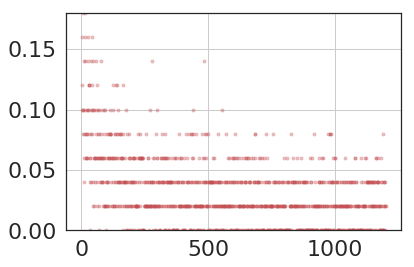

In [20]:
plt.plot(p[::100], 'r.', alpha=0.3)
plt.grid()
plt.ylim([0,0.18])
plt.show()

In [21]:
interv = 100

In [22]:
q = [np.mean(p[i:i+interv]) for i in range(len(p)-interv)]

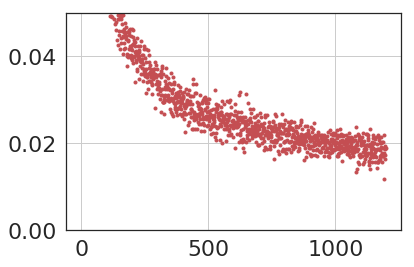

In [23]:
plt.plot(q[::100], 'r.')
plt.grid()
plt.ylim([0,0.05])
plt.show()

In [24]:
interv = 1000

In [25]:
q1 = [np.mean(p[i:i+interv]) for i in range(len(p)-interv)]

In [83]:
qqq1 = [np.mean(ppp[i:i+interv]) for i in range(len(ppp)-interv)]

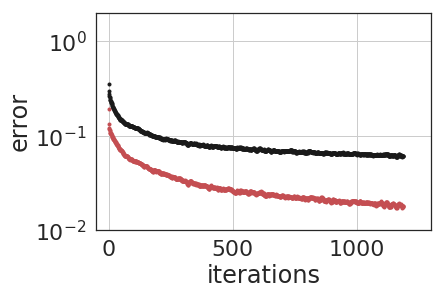

In [85]:
plt.semilogy(q1[::100], 'r.')
plt.semilogy(qqq1[::100], 'k.')

plt.grid()
plt.yticks([0.01,0.1,1])
plt.ylim([0.01,2.])
plt.xlim([-50,1300])
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()

In [27]:
intervmax = 10

In [28]:
qmax = [np.max(p[i:i+interv]) for i in range(len(p)-interv)]

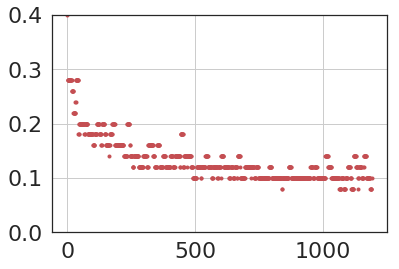

In [29]:
plt.plot(qmax[::100], 'r.')
plt.grid()
plt.ylim([0,0.4])
plt.show()

In [86]:
train_loss_list = [i[0].cpu().data.numpy()for i in data]

In [87]:
robust_loss_list = [i[1].cpu().data.numpy() for i in data]

In [88]:
tll1 = [np.mean(train_loss_list[i:i+interv]) for i in range(len(train_loss_list)-interv)]

In [89]:
rll1 = [np.mean(robust_loss_list[i:i+interv]) for i in range(len(robust_loss_list)-interv)]

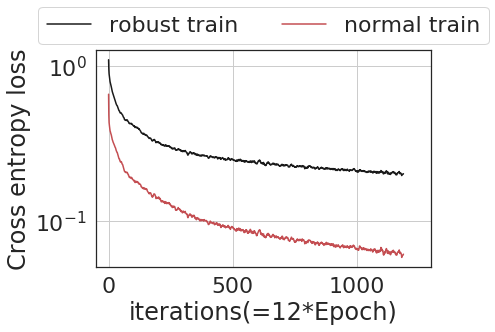

In [117]:
p1 = plt.semilogy(rll1[::100], 'k')
p2 = plt.semilogy(tll1[::100], 'r')

plt.grid()
#plt.yticks([0.01,0.1,1])
#plt.ylim([0.01,2.])
plt.xlim([-50,1300])
plt.xlabel('iterations(=12*Epoch)')
plt.ylabel('Cross entropy loss')
plt.legend((p1[0], p2[0]), ('robust train', 'normal train'), loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)

plt.show()

In [31]:
with open('robust_net.pkl', 'wb') as output:
    pickle.dump(robust_net, output, pickle.HIGHEST_PROTOCOL)

In [32]:
del robust_ce
del robust_err

# Test

In [33]:
st = time.time()

test_list = []
for j, (batch_images, batch_labels) in enumerate(test_data_loader):
    X = Variable(batch_images.cuda())
    Y = Variable(batch_labels.cuda())        

    out = robust_net.cuda()(X)
    robust_ce, robust_err = robust_loss(robust_net.cuda(), epsilon, X, batch_labels.cuda())


    l2 = nn.CrossEntropyLoss()(out, Y)
    err = (out.max(1)[1].data != batch_labels.cuda()).float().mean()

    test_list.append((robust_ce.cpu().data.numpy(), robust_err,l2.cpu().data.numpy(), err.cpu().data.numpy()))
    if j % 10 == 0:
         print('%.2f %%'%(100*j/(n_samples/(batch_size))), end='\r')
#         if j % 10 == 0 and j != (n_samples//batch_size-1):
#             print('.', end='')
#         if j == (n_samples//batch_size-1):
#             print('.')            
print('='*60)
robust_ce = np.mean(np.array([i[0] for i in test_list]))
robust_err = np.mean(np.array([i[1] for i in test_list]))
l2 = np.mean(np.array([i[2] for i in test_list]))
err = np.mean(np.array([i[3] for i in test_list]))

print('Robust xentropy loss: %.4f, Robust err: %.3f'%(robust_ce, robust_err))
print('Plain loss: %.5f, Plain err: %.5f'%(l2, err))
tt = time.time()-st
print('time taken: ', tt)

Robust xentropy loss: 0.2330, Robust err: 0.066
Plain loss: 0.07398, Plain err: 0.02220
time taken:  7.282047510147095


In [34]:
def mean(l): 
    return sum(l)/len(l)

def _fgs(model, X, y, epsilon): 
    opt = optim.Adam([X], lr=1e-3)
    out = model(X)
    ce = nn.CrossEntropyLoss()(out, y)
    err = (out.data.max(1)[1] != y.data).float().sum()  / X.size(0)

    opt.zero_grad()
    ce.backward()
    eta = X.grad.data.sign()*epsilon
    
    X_fgs = Variable(X.data + eta)
    err_fgs = (model(X_fgs).data.max(1)[1] != y.data).float().sum()  / X.size(0)
    return err, err_fgs

def fgs(loader, model, epsilon, verbose=False, robust=False): 
    return attack(loader, model, epsilon, verbose=verbose, atk=_fgs,
                  robust=robust)


def _pgd(model, X, y, epsilon, niters=100, alpha=0.01): 
    out = model(X)
    ce = nn.CrossEntropyLoss()(out, y)
    err = (out.data.max(1)[1] != y.data).float().sum()  / X.size(0)

    X_pgd = Variable(X.data, requires_grad=True)
    for i in range(niters): 
        opt = optim.Adam([X_pgd], lr=1e-3)
        opt.zero_grad()
        loss = nn.CrossEntropyLoss()(model(X_pgd), y)
        loss.backward()
        eta = alpha*X_pgd.grad.data.sign()
        X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
        
        # adjust to be within [-epsilon, epsilon]
        eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
        X_pgd = Variable(X.data + eta, requires_grad=True)
        
    err_pgd = (model(X_pgd).data.max(1)[1] != y.data).float().sum() / X.size(0)
    return err, err_pgd

def pgd(loader, model, epsilon, niters=100, alpha=0.01, verbose=False,
        robust=False):
    return attack(loader, model, epsilon, verbose=verbose, atk=_pgd,
                  robust=robust)

def attack(loader, model, epsilon, verbose=False, atk=None,
           robust=False):
    
    total_err, total_fgs, total_robust = [],[],[]
    if verbose: 
        print("Requiring no gradients for parameters.")
    for p in model.parameters(): 
        p.requires_grad = False
    
    for i, (X,y) in enumerate(loader):
        X,y = Variable(X.cuda(), requires_grad=True), Variable(y.cuda().long())

        if y.dim() == 2: 
            y = y.squeeze(1)
        
        if robust: 
            robust_ce, robust_err = robust_loss(model, epsilon, X, y, True, False)

        err, err_fgs = atk(model, X, y, epsilon)
        
        total_err.append(err.cpu().data.numpy())
        total_fgs.append(err_fgs.cpu().data.numpy())
        if robust: 
            total_robust.append(robust_err)
        if verbose:
            if i%10 == 0:
                if robust: 
                    print('err: {} | attack: {} | robust: {}'.format(err, err_fgs, robust_err))
                else:
                    print('err: {} | attack: {}'.format(err, err_fgs))
    
    if robust:         
        print('[TOTAL] err: {} | attack: {} | robust: {}'.format(mean(total_err), mean(total_fgs), mean(total_robust)))
    else:
        print('[TOTAL] err: {} | attack: {}'.format(mean(total_err), mean(total_fgs)))
    return np.array(total_err), np.stack(total_fgs), np.stack(total_robust)


In [35]:
total_err, total_pdg, total_robust = pgd(test_data_loader, robust_net, epsilon, verbose=True, robust=True)

Requiring no gradients for parameters.
err: 0.019999999552965164 | attack: 0.03999999910593033 | robust: 0.08
err: 0.019999999552965164 | attack: 0.019999999552965164 | robust: 0.08
err: 0.03999999910593033 | attack: 0.05999999865889549 | robust: 0.08
err: 0.019999999552965164 | attack: 0.019999999552965164 | robust: 0.04
err: 0.019999999552965164 | attack: 0.03999999910593033 | robust: 0.08
err: 0.019999999552965164 | attack: 0.019999999552965164 | robust: 0.04
err: 0.0 | attack: 0.0 | robust: 0.0
err: 0.019999999552965164 | attack: 0.05999999865889549 | robust: 0.06
err: 0.0 | attack: 0.0 | robust: 0.02
err: 0.019999999552965164 | attack: 0.019999999552965164 | robust: 0.04
err: 0.0 | attack: 0.03999999910593033 | robust: 0.06
err: 0.03999999910593033 | attack: 0.03999999910593033 | robust: 0.04
err: 0.019999999552965164 | attack: 0.019999999552965164 | robust: 0.06
err: 0.03999999910593033 | attack: 0.07999999821186066 | robust: 0.12
err: 0.03999999910593033 | attack: 0.059999998658